### Model 6. Seasonal autoregressive integraded moving average model (SARIMA)

SARIMA($p$, $d$, $q$)($P$, $D$, $Q$, $s$) is able to model non-stationary model. It is actually the combination of several component models which are introduced breifly below.

1. Seasonality S($P$, $D$, $Q$, $s$): $s$ is simply the season's length. Definitions of $P$, $Q$ are similar to those of p and q below, but for the seasonal component. $D$ is the order of seasonal integration representing the number of differences required to remove seasonality from the series.

2. Autoregressive model AR($p$): This is basically a regression of the time series onto itself. Here, we assume that the current values depends on its previous values with some lag.

3. Order of Integration I($d$): Parameter $d$ is the number of differences required to make the series stationary.

4. Moving Average MA($q$): Parameter $q$ is the biggest lag after which other lags are not significant on the autocorrelation plot

#### Stationarity

A time series is said to be stationary if its statistical properties (constant mean, variance) do not change over time.

A stationary time series is ideal because it is easier to model. However, stock price is frequently not stationary as we often see a growing/declining trend or its variance is changing under different economic contexts.

In [1]:
import pandas as pd
GOOGL = pd.read_csv('data/GOOGL.csv')

In [2]:
from tqdm import tqdm_notebook
from itertools import product
import statsmodels.api as sm
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

In below, we fix the parameters $d, D, s$

In [3]:
#Set initial values and some bounds
ps = range(18, 19)
d = 1
qs = range(0, 7)
Ps = range(0, 5)
D = 1
Qs = range(0, 5)
s = 5

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

175

#### Akaike Information Criterion (AIC)
AIC is a method for evaluating how well a model fits the data it was generated from. 
In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data.

AIC is calculated from the number of independent variables used to build the model and the maximum likelihood estimate of the model.

The best-fit model according to AIC is the one that explains the greatest amount of variation using the fewest possible independent variables.

In [4]:
def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm_notebook(parameters_list):
        try: model = sm.tsa.statespace.SARIMAX(GOOGL['4. close'][:80], order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

result_table = optimize_SARIMA(parameters_list, d, D, s)

  0%|          | 0/175 [00:00<?, ?it/s]

In [5]:
#Set parameters that give the lowest AIC (Akaike Information Criteria)
print(result_table)
p, q, P, Q = result_table.parameters[0]

best_model = sm.tsa.statespace.SARIMAX(GOOGL['4. close'][:80], order=(p, d, q),
                                       seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

       parameters         aic
0   (18, 1, 0, 0)  839.681403
1   (18, 0, 0, 1)  839.807644
2   (18, 0, 0, 2)  841.369671
3   (18, 0, 0, 0)  841.402971
4   (18, 2, 0, 0)  841.479647
5   (18, 1, 0, 1)  841.693986
6   (18, 3, 0, 0)  841.825167
7   (18, 0, 0, 4)  842.586170
8   (18, 1, 0, 2)  842.980111
9   (18, 2, 0, 1)  843.102655
10  (18, 2, 0, 2)  844.509162
11  (18, 0, 0, 3)  844.590829
12  (18, 1, 0, 4)  844.746360
13  (18, 3, 0, 1)  844.965288
14  (18, 6, 0, 0)  845.284313
15  (18, 3, 0, 2)  845.465032
16  (18, 4, 0, 1)  845.898542
17  (18, 4, 0, 0)  846.340350
18  (18, 1, 0, 3)  846.565996
19  (18, 2, 0, 3)  846.613844
20  (18, 2, 0, 4)  846.992711
21  (18, 5, 0, 0)  847.118276
22  (18, 4, 0, 2)  847.711012
23  (18, 3, 0, 3)  848.523452
24  (18, 3, 0, 4)  848.859689
25  (18, 4, 0, 3)  849.304349
26  (18, 4, 0, 4)  851.268436
                                      SARIMAX Results                                      
Dep. Variable:                            4. close   No. Observation

In the following, we calculate the MSE in order to compare SARIMA with other models.

In [6]:
from sklearn.metrics import mean_squared_error
mean_squared_error(
    best_model.predict(start=81, end=100), 
    GOOGL['4. close'][-20:])

1866.2268436478691

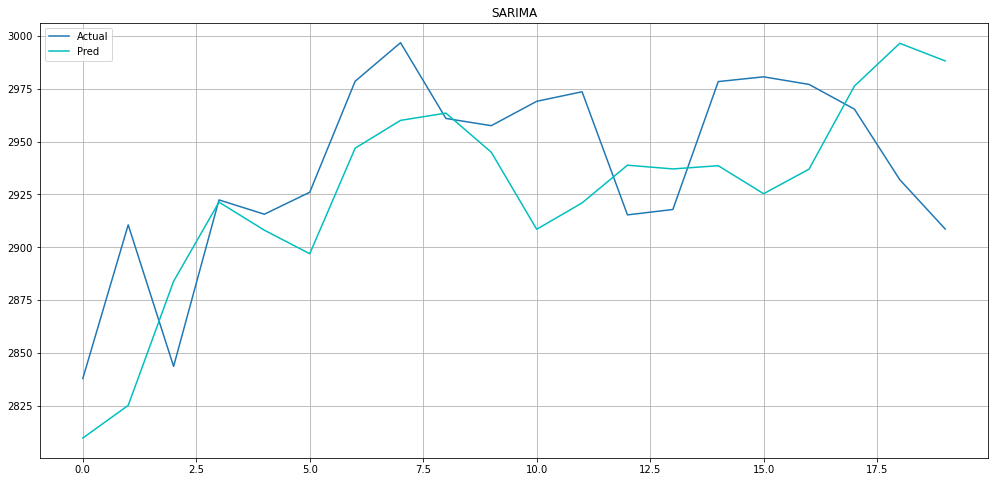

In [7]:
import matplotlib.pyplot as plt
def plot(series_true, series_pred):
    plt.figure(figsize=(17, 8))
    plt.plot(series_true.values, label = "Actual")
    plt.plot(series_pred.values, "c", label = "Pred")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("SARIMA")
    plt.grid(True);
plot(GOOGL['4. close'][-20:], best_model.predict(start=81, end=100))

In [8]:
print(best_model.predict(start=0, end=100))

0         0.000000
1      2834.745463
2      2832.274984
3      2765.178604
4      2797.149377
          ...     
96     2925.340819
97     2936.952559
98     2976.246783
99     2996.482431
100    2988.150176
Name: predicted_mean, Length: 101, dtype: float64
